In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from sklearn.neural_network import MLPRegressor

In [2]:
# Generate synthetic data
np.random.seed(42)
torch.manual_seed(42)
n_samples = 200
n_features = 5
X = np.random.rand(n_samples, n_features)
y = np.random.randint(1, 6, size=n_samples)  # Relevance scores between 1 and 5

In [4]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [7]:

# Define a simple neural network
class RankNet(nn.Module):
    def __init__(self, input_dim):
        super(RankNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    
    def forward(self, x):
        return self.model(x).squeeze()

# ListNet loss function
def listnet_loss(y_pred, y_true):
    """
    Computes the ListNet loss based on the cross-entropy of the predicted and true distributions.
    """
    y_pred_softmax = torch.softmax(y_pred, dim=0)
    y_true_softmax = torch.softmax(y_true, dim=0)
    return -torch.sum(y_true_softmax * torch.log(y_pred_softmax))


# ListMLE loss function
def listmle_loss(y_pred, y_true):
    """
    Computes the ListMLE loss based on the log-likelihood of the predicted permutation.
    """
    # Sort by true relevance
    _, sorted_indices = torch.sort(y_true, descending=True)
    y_pred_sorted = y_pred[sorted_indices]
    # Compute loss as negative log likelihood
    return -torch.sum(torch.log(torch.softmax(y_pred_sorted, dim=0)))

# Train the model
def train_model(model, loss_fn, X_train, y_train, lr=0.01, epochs=500):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
    return model



In [8]:
# Initialize models
listnet_model = RankNet(input_dim=n_features)
listmle_model = RankNet(input_dim=n_features)

# Train models
listnet_model = train_model(listnet_model, listnet_loss, X_train_tensor, y_train_tensor)
listmle_model = train_model(listmle_model, listmle_loss, X_train_tensor, y_train_tensor)


In [6]:

# Train and predict with ListMLE
listmle = ListMLE()
listmle.fit(X_train, y_train)
y_pred_listmle = listmle.predict(X_test)


/Users/thiagoclm/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
# Evaluate models
listnet_model.eval()
listmle_model.eval()
y_pred_listnet = listnet_model(X_test_tensor).detach().numpy()
y_pred_listmle = listmle_model(X_test_tensor).detach().numpy()

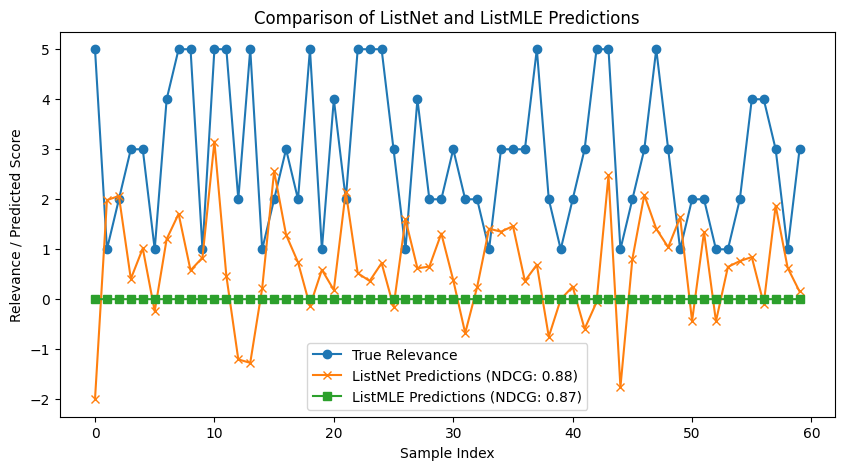

In [10]:
# Compute NDCG
ndcg_listnet = ndcg_score([y_test], [y_pred_listnet])
ndcg_listmle = ndcg_score([y_test], [y_pred_listmle])

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="True Relevance", marker="o")
plt.plot(y_pred_listnet, label=f"ListNet Predictions (NDCG: {ndcg_listnet:.2f})", marker="x")
plt.plot(y_pred_listmle, label=f"ListMLE Predictions (NDCG: {ndcg_listmle:.2f})", marker="s")
plt.legend()
plt.title("Comparison of ListNet and ListMLE Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Relevance / Predicted Score")
plt.show()

**ListNet Loss**: Computes the cross-entropy between the predicted and true relevance distributions, normalized with a softmax function. 

**ListMLE Loss**: Sorts the predictions by true relevance and computes the log-likelihood of the ranking permutation using the softmax function.